
# Neuron - Classificação de Emoções em Português

Este notebook implementa o pipeline completo de **Machine Learning** para o projeto Neuron:

1. Carregamento do dataset de frases em português.
2. Análise exploratória simples.
3. Pré-processamento de texto (PT-BR).
4. Criação de dois modelos de IA:
   - **Modelo 1**: classificação de **emoções** (`alegria, tristeza, raiva, medo, amor, surpresa`).
   - **Modelo 2**: classificação de **sentimento** (`positivo` x `negativo`).
5. Salvamento dos modelos em arquivo `.pkl`.
6. Exemplo de uso do modelo para rotular uma conversa ao longo de vários dias e gerar gráficos.


In [1]:
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Executar apenas na primeira vez no ambiente
# nltk.download('stopwords')
# nltk.download('rslp')


## 1. Carregar dados

In [2]:

# Ajuste o caminho se precisar
df = pd.read_csv("dados_humor_neuron_pt.csv")

df.head()


,texto,emocao
0,Hoje o time está bem animado com o resultado d...,alegria
1,Fiquei muito feliz com o feedback positivo do ...,alegria
2,Estou empolgado com as novas funcionalidades q...,alegria
3,O clima na empresa hoje está leve e divertido.,alegria
4,"Adorei participar da reunião de brainstorming,...",alegria


## 2. Análise exploratória simples

In [3]:
df['emocao'].value_counts()

emocao
alegria     8
tristeza    8
raiva       8
medo        8
amor        8
surpresa    8
Name: count, dtype: int64

## 3. Criar coluna de sentimento (positivo/negativo)

In [4]:

map_sent = {
    "alegria": "positivo",
    "amor": "positivo",
    "surpresa": "positivo",
    "tristeza": "negativo",
    "raiva": "negativo",
    "medo": "negativo",
}

df["sentimento"] = df["emocao"].map(map_sent)
df.head()


,texto,emocao,sentimento
0,Hoje o time está bem animado com o resultado d...,alegria,positivo
1,Fiquei muito feliz com o feedback positivo do ...,alegria,positivo
2,Estou empolgado com as novas funcionalidades q...,alegria,positivo
3,O clima na empresa hoje está leve e divertido.,alegria,positivo
4,"Adorei participar da reunião de brainstorming,...",alegria,positivo


## 4. Pré-processamento de texto em PT-BR

In [5]:

# garantir que os recursos do NLTK estejam disponíveis
try:
    stopwords_pt = set(stopwords.words("portuguese"))
except LookupError:
    nltk.download("stopwords")
    stopwords_pt = set(stopwords.words("portuguese"))

try:
    stemmer = RSLPStemmer()
except LookupError:
    nltk.download("rslp")
    stemmer = RSLPStemmer()

def preprocess_pt(texto: str) -> str:
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = re.sub(r"[^a-záéíóúâêôãõç\s]", " ", texto)
    tokens = texto.split()
    tokens = [t for t in tokens if t not in stopwords_pt]
    tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

df["texto_limpo"] = df["texto"].apply(preprocess_pt)
df[["texto", "texto_limpo", "emocao", "sentimento"]].head()


,texto,texto_limpo,emocao,sentimento
0,Hoje o time está bem animado com o resultado d...,hoj tim bem anim result sprint,alegria,positivo
1,Fiquei muito feliz com o feedback positivo do ...,fiq feliz feedback posi client,alegria,positivo
2,Estou empolgado com as novas funcionalidades q...,empolg nov funcional vam lanç,alegria,positivo
3,O clima na empresa hoje está leve e divertido.,clim empr hoj lev divert,alegria,positivo
4,"Adorei participar da reunião de brainstorming,...",ador particip reun brainstorming inspir,alegria,positivo


## 5. Separar treino e teste

In [6]:
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2, random_state=42, stratify=df["emocao"]
)

X_train = df.loc[train_idx, "texto_limpo"]
X_test = df.loc[test_idx, "texto_limpo"]
y_emocao_train = df.loc[train_idx, "emocao"]
y_emocao_test = df.loc[test_idx, "emocao"]
y_sent_train = df.loc[train_idx, "sentimento"]
y_sent_test = df.loc[test_idx, "sentimento"]

len(X_train), len(X_test)


(38, 10)

## 6. Vetorização TF-IDF

In [7]:

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

X_train_vec.shape, X_test_vec.shape


((38, 142), (10, 142))

## 7. Modelo 1 – Classificação de Emoções

In [8]:

modelo_emocao = LogisticRegression(max_iter=1000, multi_class="multinomial")
modelo_emocao.fit(X_train_vec, y_emocao_train)

y_pred_emocao = modelo_emocao.predict(X_test_vec)
print("Accuracy EMOÇÃO:", accuracy_score(y_emocao_test, y_pred_emocao))
print(classification_report(y_emocao_test, y_pred_emocao))


Accuracy EMOÇÃO: 0.1
              precision    recall  f1-score   support

     alegria       0.00      0.00      0.00         1
        amor       0.00      0.00      0.00         1
        medo       1.00      0.50      0.67         2
       raiva       0.00      0.00      0.00         2
    surpresa       0.00      0.00      0.00         2
    tristeza       0.00      0.00      0.00         2

    accuracy                           0.10        10
   macro avg       0.17      0.08      0.11        10
weighted avg       0.20      0.10      0.13        10



C:\Users\tiago\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tiago\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tiago\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

## 8. Modelo 2 – Classificação de Sentimento (positivo/negativo)

In [9]:

modelo_sentimento = LogisticRegression(max_iter=1000)
modelo_sentimento.fit(X_train_vec, y_sent_train)

y_pred_sent = modelo_sentimento.predict(X_test_vec)
print("Accuracy SENTIMENTO:", accuracy_score(y_sent_test, y_pred_sent))
print(classification_report(y_sent_test, y_pred_sent))


Accuracy SENTIMENTO: 0.4
              precision    recall  f1-score   support

    negativo       0.50      0.33      0.40         6
    positivo       0.33      0.50      0.40         4

    accuracy                           0.40        10
   macro avg       0.42      0.42      0.40        10
weighted avg       0.43      0.40      0.40        10



## 9. Salvar modelos em arquivo `.pkl`

In [10]:

artefatos = {
    "vectorizer": vectorizer,
    "modelo_emocao": modelo_emocao,
    "modelo_sentimento": modelo_sentimento,
}

with open("modelos_neuron_pt.pkl", "wb") as f:
    pickle.dump(artefatos, f)

print("Modelos salvos em 'modelos_neuron_pt.pkl'")


Modelos salvos em 'modelos_neuron_pt.pkl'


## 10. Exemplo – Classificar uma conversa e gerar análise por dia

In [11]:

# Carrega modelos (caso esteja em outro ambiente)
with open("modelos_neuron_pt.pkl", "rb") as f:
    artefatos2 = pickle.load(f)

vectorizer2 = artefatos2["vectorizer"]
modelo_emocao2 = artefatos2["modelo_emocao"]
modelo_sent2 = artefatos2["modelo_sentimento"]

# Exemplo de conversa com timestamps
dados_conversa = [
    {"timestamp": "2025-11-14 09:10:00", "texto": "Bom dia, estou bem cansado e desmotivado hoje."},
    {"timestamp": "2025-11-14 11:30:00", "texto": "A reunião foi ótima, estou animado com o resultado."},
    {"timestamp": "2025-11-15 10:05:00", "texto": "Estou preocupado com o prazo, com medo de atrasar."},
    {"timestamp": "2025-11-15 16:40:00", "texto": "Adorei o feedback do cliente, fiquei muito feliz."},
]

df_msgs = pd.DataFrame(dados_conversa)
df_msgs["timestamp"] = pd.to_datetime(df_msgs["timestamp"])
df_msgs["data"] = df_msgs["timestamp"].dt.date

df_msgs["texto_limpo"] = df_msgs["texto"].apply(preprocess_pt)
X_msgs = vectorizer2.transform(df_msgs["texto_limpo"])

df_msgs["emocao"] = modelo_emocao2.predict(X_msgs)
df_msgs["sentimento"] = modelo_sent2.predict(X_msgs)

df_msgs


,timestamp,texto,data,texto_limpo,emocao,sentimento
0,2025-11-14 09:10:00,"Bom dia, estou bem cansado e desmotivado hoje.",2025-11-14,bom dia bem cans desmotiv hoj,tristeza,negativo
1,2025-11-14 11:30:00,"A reunião foi ótima, estou animado com o resul...",2025-11-14,reun ótim anim result,alegria,positivo
2,2025-11-15 10:05:00,"Estou preocupado com o prazo, com medo de atra...",2025-11-15,preocup praz med atras,medo,negativo
3,2025-11-15 16:40:00,"Adorei o feedback do cliente, fiquei muito feliz.",2025-11-15,ador feedback client fiq feliz,alegria,positivo


### Gráficos de emoções e sentimento por dia

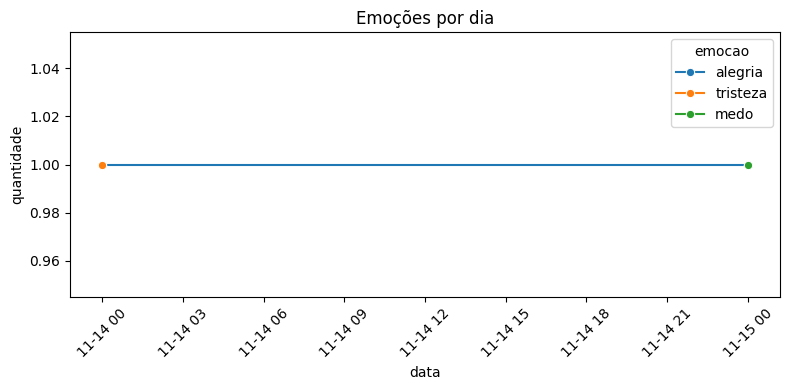

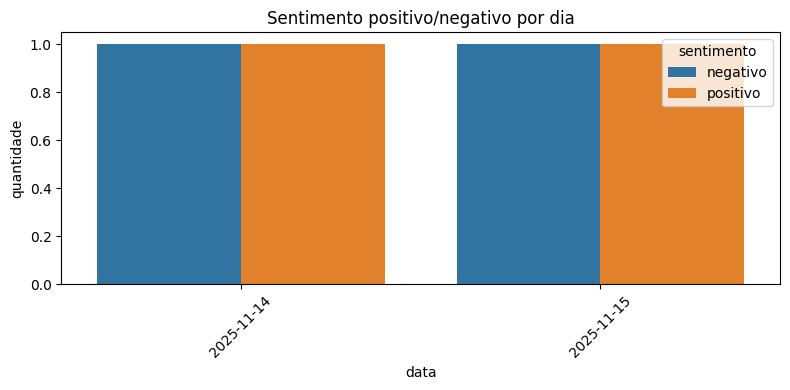

In [12]:

emocoes_por_dia = (
    df_msgs.groupby(["data", "emocao"])
           .size()
           .reset_index(name="quantidade")
)

plt.figure(figsize=(8,4))
sns.lineplot(data=emocoes_por_dia, x="data", y="quantidade", hue="emocao", marker="o")
plt.title("Emoções por dia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sent_por_dia = (
    df_msgs.groupby(["data", "sentimento"])
           .size()
           .reset_index(name="quantidade")
)

plt.figure(figsize=(8,4))
sns.barplot(data=sent_por_dia, x="data", y="quantidade", hue="sentimento")
plt.title("Sentimento positivo/negativo por dia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
